In [272]:
#imports

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_predict,
                                     cross_validate, train_test_split)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from collections import Counter
from sklearn.linear_model import LogisticRegression
import statistics
import shap


random_state = 42

In [273]:
#ds loading and variables removal 
ds = pd.read_csv(r"C:\Users\USER\OneDrive\Summer_project\Azure\annex study\ds_annex_study.csv", index_col = 'ID')
ds = ds.drop(columns=['date','DOB', 'preexisting_cond', 'twoyears', 'fiveyears', 'death'])

In [274]:
#Extra preprocessing (1-hot encoding)
ds = ds.fillna(ds.mean())
ds = ds.fillna(0)


for variable in ['COPD', 'ILD', 'NTM']:
    ds[variable][ds[variable] == 'Yes'] = 1
    ds[variable][ds[variable] == 'No'] = 0

ds['sex'][ds['sex'] == 'F'] = 0
ds['sex'][ds['sex'] == 'M'] = 1

ds.ethnicity = ds.ethnicity.astype('category').cat.codes

labels2 = ds['dead2']
labels5 = ds['dead5']

ds = ds.drop(columns = ['dead2', 'dead5'])

counter2 = Counter(labels2)
counter5 = Counter(labels5)

print('2 years', counter2)
print('5 years', counter5)

counter = counter5

# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
estimate2 = counter[1]/counter[0]

#dataset split 
X_train, X_test, y_train, y_test = train_test_split(ds, labels2, test_size=0.2, shuffle = True, random_state=random_state)
features = ds.columns
ds = np.array(ds)
labels2 = np.array(labels2)


2 years Counter({0: 61, 1: 24})
5 years Counter({0: 46, 1: 39})


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


[[0 64 0 3.0 38.0 15.0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 58 5 5.0 37.0 22.0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0]
 [1 54 1 4.0 43.0 21.2764705882353 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1
  1]
 [0 25 1 4.0 42.0 19.1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 61 1 40.0 34.0 17.7 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1]
 [1 62 1 13.0 39.0 19.5 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1]
 [1 74 1 2.0 42.0 25.3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 84 1 9.0 35.0 22.9 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
 [0 37 1 159.0 38.0 13.5 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0]
 [0 51 1 10.0 43.0 21.6 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1]
 [0 66 1 19.0 30.0 20.8 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 62 1 2.0 45.0 22.3 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 68 1 117.0 36.0 26.0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]
 [1 82 1 30.0 33.0 21.2764705882353 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0]
 [0 53 5 20.0 32.0 21.2764705882353 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0

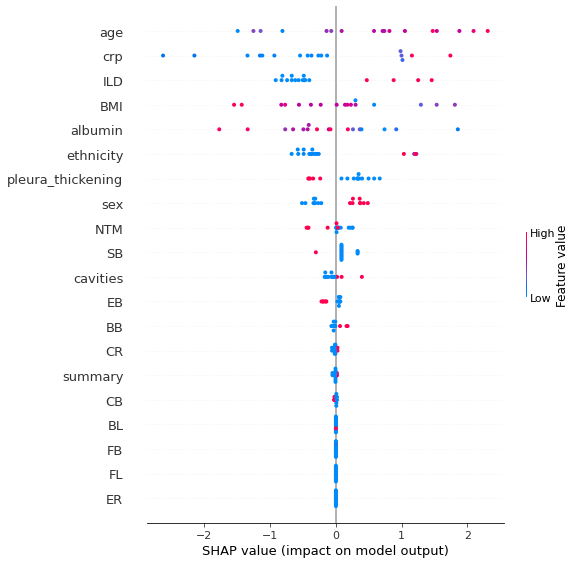

[[0 46 7 8.0 36.0 29.2 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1]
 [1 58 1 36.37179487179487 38.1025641025641 19.6 0 0 0 0 0 1 0 0 0 0 0 0
  0 1 0 0 0 0 1 1]
 [0 63 1 6.0 43.0 19.2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 78 1 13.0 40.0 22.7 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 49 6 12.0 43.0 20.8 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1]
 [0 47 7 27.0 41.0 27.0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1]
 [1 69 1 10.0 39.0 15.5 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1]
 [0 53 1 8.0 44.0 26.7 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 54 3 22.0 36.0 21.4 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 54 1 146.0 28.0 21.2764705882353 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
  1 1]
 [1 40 1 105.0 41.0 23.0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 46 1 5.0 45.0 25.8 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
 [1 87 1 29.0 32.0 21.2764705882353 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1
  1]
 [1 47 1 137.0 33.0 14.6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [1 53 1 6.0 32.0 20.1 0 0 0 0 0 0 0

<Figure size 432x288 with 0 Axes>

In [275]:
SHAP = True

# model = RandomForestClassifier(random_state=random_state, class_weight = {0:estimate2, 1:estimate})
model = XGBClassifier(random_state=random_state, scale_pos_weight = estimate)
# model = LogisticRegression(random_state = random_state)
labels = labels5

#model training
skf = KFold(n_splits=5, random_state=random_state, shuffle=True)
acc = []
cms = []
f1 = []

for train_index, test_index in skf.split(ds, labels):
    X_train, X_test = ds[train_index], ds[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    print(X_test)
    xgbc = model
    xgbc.fit(X_train, y_train)
    y_pred = xgbc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cf = confusion_matrix(y_test, y_pred)
    fscore = f1_score(y_test, y_pred)
    acc.append(accuracy)
    cms.append(cf)
    f1.append(fscore)
    print('Accuracy:', round(accuracy,2))
    print('F1-score:', round(fscore,2))
    print('Confusion matrix:\n', cf)

    if SHAP:
        ex = shap.Explainer(model)
        shaps_values = ex.shap_values(X_test)
        plt.figure(figsize = (15,15))
        shap.summary_plot(shaps_values, pd.DataFrame(X_test.astype('float'), columns = features), show = True)
        plt.savefig('SHAP_CPA.png',bbox_inches='tight', dpi=300)
        SHAP = False

print('Averaged accuracy (5-folds): %.3f ±  %.3f' % (np.mean(acc), statistics.stdev(acc)))
print('Averaged f1-score (5-folds): %.3f ±  %.3f' % (np.mean(f1), statistics.stdev(f1)))

